In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import bisect
import opticslib as ol

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
inch_ = 25.4e-3
centi_ = 1e-2
milli_ = 1e-3


## misc

In [136]:
angle_left = 153 + 2/60.0 + 57/3600
angle_right = 153 + 27/60.0 + 30/3600

angle_half = np.deg2rad((angle_right - angle_left)/2)

diameter = 0.2575

focal_len = diameter / (2 * np.tan(angle_half))
print(f'focal len = {focal_len:0.6f} in')

focal len = 36.057679 in


# beamline

In [154]:
LENS1_POS = 35.30 * inch_
DRIFT1_DIST = 72 * inch_
DRIFT2_DIST = 2.125 * inch_

namelist = ['lens_01',
            'telescope_01',
            'telescope_02'
           ]

eletypelist = ['lens','lens','lens']

distlist =  [LENS1_POS, DRIFT1_DIST, DRIFT2_DIST]
current_point_ = 0.0
poslist = []
for d in distlist:
    current_point_ += d
    poslist.append(current_point_)

foclist = [ 35.30 * inch_,
           -10.0 * inch_,
            10.0 * inch_
          ]

elementlist = []
for i,ele in enumerate(namelist):
    elementlist.append(ol.BLElement(ele, eleprops={'eletype':eletypelist[i],'position':poslist[i], 'focal_len':foclist[i]}))


BLUV = ol.BeamLine()
for i,ele in enumerate(elementlist):
    BLUV.add_element(ele)


In [69]:
# make beam
STD_POS = (0.255/2) * inch_
STD_ANG = 1.0E-3
NMACRO = 50
invec01 = np.stack((np.random.normal(0.0, STD_POS, NMACRO),
                    np.random.normal(0.0, STD_ANG, NMACRO)))
INPOS = 0.0
OUTPOS = np.array([150.0*inch_])
outpos01 = np.arange(0.0,OUTPOS,0.25*inch_)
outpos01, outvec01, outvec_mean, outvec_rms = BLUV.ray_trace(invec01, INPOS, outpos01)

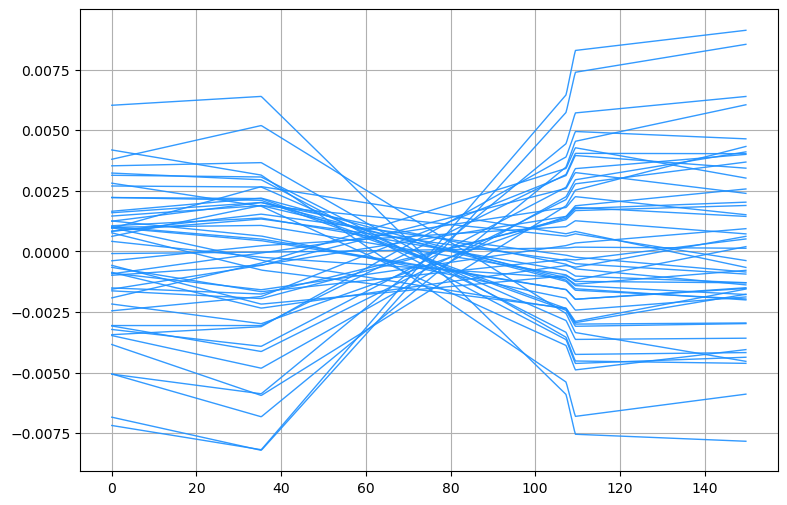

In [70]:

fig, ax = plt.subplots(figsize=(9,6))

ls = dict(color='dodgerblue',linewidth=1,linestyle='-',marker='o',ms=0, mfc='None', alpha=0.91)
xvec = outpos01

for i in range(invec01.shape[1]):
    yvec = outvec01[:,0,i]
    plt.plot(xvec/inch_, yvec,**ls)

plt.grid(True)

### scan
---

In [551]:
elementlist = [cl.ElementABCD('lens_01', eletype='lens', eleprops={'position':0,'focal_len':1.1}),
               cl.ElementABCD('lens_03', eletype='lens', eleprops={'position':1,'focal_len':3}),
               cl.ElementABCD('lens_04', eletype='lens', eleprops={'position':7,'focal_len':3}),
               cl.ElementABCD('lens_04', eletype='lens', eleprops={'position':7.5,'focal_len':2.5})]
BLUV = cl.BeamLine()
for i,ele in enumerate(elementlist):
    BLUV.add_element(ele)

lens2position = np.arange(0.05,0.15,0.01)
stdposfinal = np.zeros(lens2position.shape)

for i,l2pos in enumerate(lens2position):

    lens2 = cl.ElementABCD('lens_02', eletype='lens', eleprops={'position':l2pos,'focal_len':-1})
    BLUV.add_element(lens2)

    outpostemp, outvectemp = BLUV.ray_trace(invec01, INPOS, OUTPOS)
    stdposfinal[i] = outvectemp[-1,0,:].std()

    BLUV.del_element('lens_02')



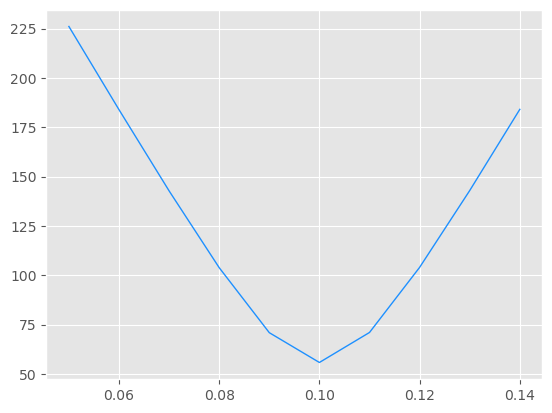

In [552]:
plt.style.use('ggplot')
ls = dict(linewidth=1,linestyle='-',marker='o',ms=0, mfc='None', alpha=1)
ls['color'] = 'dodgerblue'
xvec = lens2position
yvec = 1e6 * stdposfinal
plt.plot(xvec, yvec,**ls)
# plt.axis([lens2position.min(), lens2position.max(), 0, 500])
plt.style.use('default')

In [526]:
outvectemp[-1,0,:].std()

0.00015935975342565878

### principal rays
---

In [159]:
R0 = (0.255/2) * inch_
A0 = 7.2e-3
invec01 = np.array([[R0, -R0],[0, 0]])
invec011 = np.array([[0, 0],[A0, -A0]])
invec01 = np.concatenate((invec01, invec011), axis=1)
# invec02 = np.array([[R0, -R0],[0.1*A0, 0.1*A0]])
# invec01 = np.concatenate((invec01, invec02), axis=1)
# invec02 = np.array([[0, 0],[A0 + 0.5*A0, -A0 + 0.5*A0]])
# invec01 = np.concatenate((invec01, invec02), axis=1)
# invec01
inpos01 = 0
outpos01 = np.arange(0.0,175,0.25)*inch_
# outpos01, outvec01 = BL_01.ray_trace(invec01, inpos01, outpos01)
outpos01, outvec01,outvec_mean, outvec_rms = BLUV.ray_trace(invec01, inpos01, outpos01)

(110.0, 125.0)

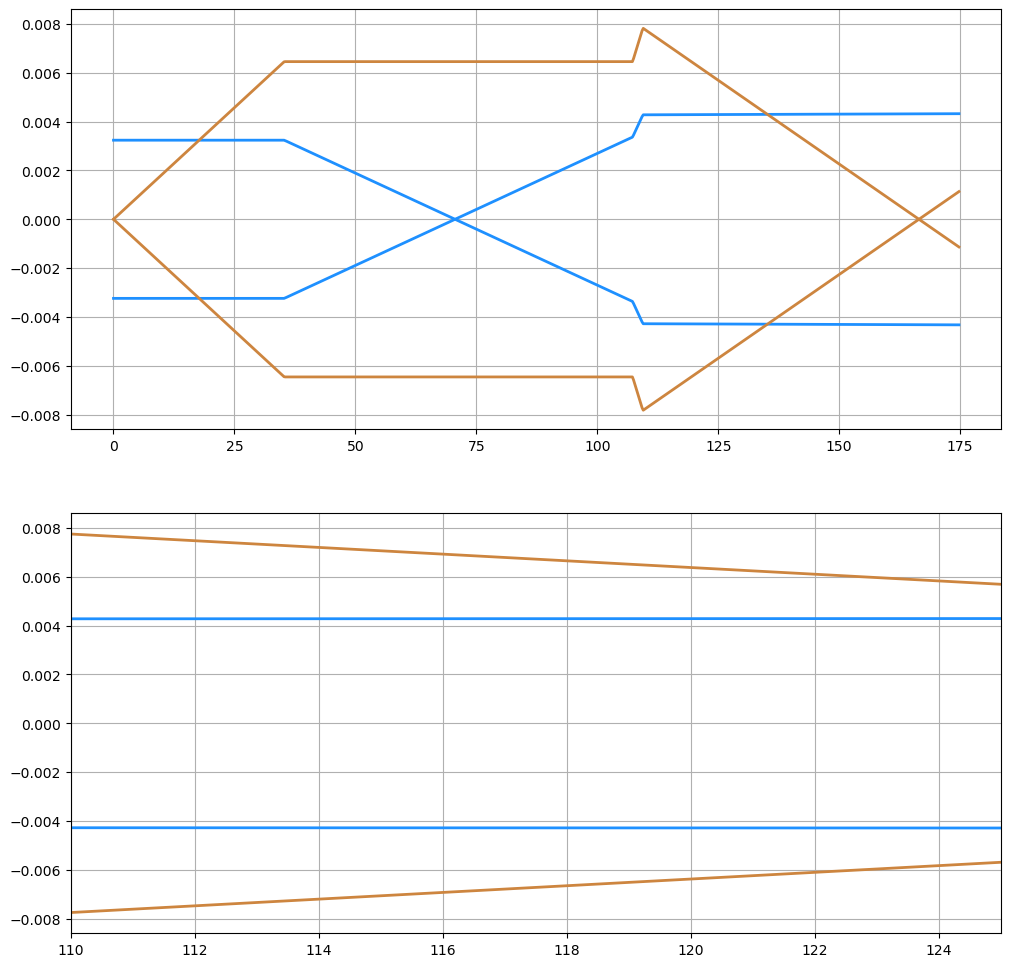

In [160]:
xvec = outpos01/inch_
colorlist_ = ['dodgerblue','peru','tab:green', 'tab:red']
ls = dict(linewidth=2,linestyle='-',marker='o',ms=0, mfc='None', alpha=1)
fig, ax = plt.subplots(2,1,figsize=(12,12))

for i in range(invec01.shape[1]):
    yvec = outvec01[:,0,i]
    ls['color'] = colorlist_[i//2]

    ax[0].plot(xvec, yvec,**ls)
    ax[1].plot(xvec, yvec,**ls)

ax[0].grid(True)
ax[1].grid(True)
ax[1].set_xlim([110,125])

In [442]:
R0 = 1e-3
invec01 = np.array([[R0, 0, -R0],[0,0,0]])
inpos01 = -1
outpos01 = np.arange(10.0,11.5,0.025)
# outpos01, outvec01 = BL_01.ray_trace(invec01, inpos01, outpos01)
outpos01, outvec01 = BLUV.ray_trace(invec01, inpos01, outpos01)

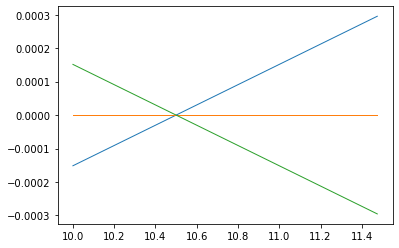

In [443]:
xvec = outpos01[1:]
for i in range(invec01.shape[1]):
    yvec = outvec01[1:,0,i]
    ls = dict(linewidth=1,linestyle='-',marker='o',ms=0, mfc='None', alpha=1)
    plt.plot(xvec, yvec,**ls)

# Objective lens
---

In [93]:
FL0 = 0.25
DL0 = 0.05
POS0 = 0.0
elementlistx = [cl.ElementABCD('lens_01', eletype='lens', eleprops={'position':POS0,'focal_len':FL0}),
               cl.ElementABCD('lens_02', eletype='lens', eleprops={'position':POS0 + DL0,'focal_len':-FL0}),
               cl.ElementABCD('lens_03', eletype='lens', eleprops={'position':POS0 + 2*DL0,'focal_len':FL0}),
               cl.ElementABCD('lens_04', eletype='lens', eleprops={'position':POS0 + 3*DL0,'focal_len':-FL0}),
               cl.ElementABCD('lens_05', eletype='lens', eleprops={'position':POS0 + 4*DL0,'focal_len':FL0})]
elementlisty = [cl.ElementABCD('lens_01', eletype='lens', eleprops={'position':POS0,'focal_len':-FL0}),
               cl.ElementABCD('lens_02', eletype='lens', eleprops={'position':POS0 + DL0,'focal_len':FL0}),
               cl.ElementABCD('lens_03', eletype='lens', eleprops={'position':POS0 + 2*DL0,'focal_len':-FL0}),
               cl.ElementABCD('lens_04', eletype='lens', eleprops={'position':POS0 + 3*DL0,'focal_len':FL0}),
               cl.ElementABCD('lens_05', eletype='lens', eleprops={'position':POS0 + 4*DL0,'focal_len':-FL0})]

BLQ5X = cl.BeamLine()
BLQ5Y = cl.BeamLine()
for i in range(len(elementlistx)):

    BLQ5X.add_element(elementlistx[i])
    
    BLQ5Y.add_element(elementlisty[i])


In [99]:
# make beam
STD_POS = 2E-3
STD_ANG = 0.2E-3
NMACRO = 500
invec01 = np.stack((np.random.normal(0.0, STD_POS, NMACRO),
                    np.random.normal(0.0, STD_ANG, NMACRO)))
INPOS = -0.1
OUTPOS = np.array([10.0])
outpos01 = np.arange(0.0,0.5,0.05)
outpos01x, outvec01X = BLQ5X.ray_trace(invec01, INPOS, outpos01)
outpos01y, outvec01Y = BLQ5Y.ray_trace(invec01, INPOS, outpos01)

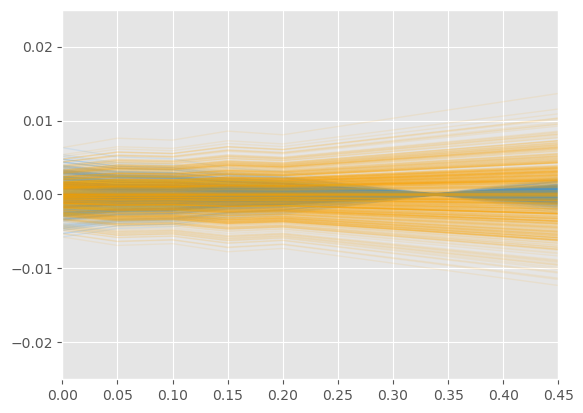

In [100]:
plt.style.use('ggplot')
ls = dict(linewidth=1,linestyle='-',marker='o',ms=0, mfc='None', alpha=0.1)
ls['color'] = 'dodgerblue'

xvec = outpos01x
for i in range(invec01.shape[1]):
    yvec = outvec01X[:,0,i]
    
    plt.plot(xvec, yvec,**ls)

ls['color'] = 'orange'
xvec = outpos01y
for i in range(invec01.shape[1]):
    yvec = outvec01Y[:,0,i]
    
    plt.plot(xvec, yvec,**ls)

plt.axis([outpos01.min(), outpos01.max(), -0.025, 0.025])
plt.style.use('default')

# Telescope
---

In [92]:

FL0 = 0.1667
DL0 = 0.2
DL1 = 0.3
DL2 = 0.1

POS0 = 0.0

elementlistx = [cl.ElementABCD('lens_01', eleprops={'eletype':'lens', 'position':POS0,'focal_len':FL0})
               ,cl.ElementABCD('lens_02', eleprops={'eletype':'lens', 'position':POS0 + DL0,'focal_len':-FL0})
               ,cl.ElementABCD('lens_03', eleprops={'eletype':'lens', 'position':POS0 + DL0 + DL1,'focal_len':FL0})
               ,cl.ElementABCD('lens_04', eleprops={'eletype':'lens', 'position':POS0 + DL0 + DL1 +DL2,'focal_len':-FL0})
               ]

elementlisty = [cl.ElementABCD('lens_01', eleprops={'eletype':'lens', 'position':POS0,'focal_len':-FL0})
               ,cl.ElementABCD('lens_02', eleprops={'eletype':'lens', 'position':POS0 + DL0,'focal_len':FL0})
               ,cl.ElementABCD('lens_03', eleprops={'eletype':'lens', 'position':POS0 + DL0 + DL1,'focal_len':-FL0})
               ,cl.ElementABCD('lens_04', eleprops={'eletype':'lens', 'position':POS0 + DL0 + DL1 +DL2,'focal_len':FL0})
               ]
BLQ4X = cl.BeamLine()
BLQ4Y = cl.BeamLine()
for i in range(len(elementlistx)):

    BLQ4X.add_element(elementlistx[i])
    
    BLQ4Y.add_element(elementlisty[i])


In [93]:
# make beam
STD_POS = 190E-6
STD_ANG = 35e-6
# STD_POS = 165E-6
# STD_ANG = 50e-6
NMACRO = 250
invec01 = np.stack((np.random.normal(0.0, STD_POS, NMACRO),
                    np.random.normal(0.0, STD_ANG, NMACRO)))
INPOS = -0.1
OUTPOS = np.array([10.0])
outpos01 = np.arange(0.0,1.5,0.05)
outpos01x, outvec01X = BLQ4X.ray_trace(invec01, INPOS, outpos01)
outpos01y, outvec01Y = BLQ4Y.ray_trace(invec01, INPOS, outpos01)

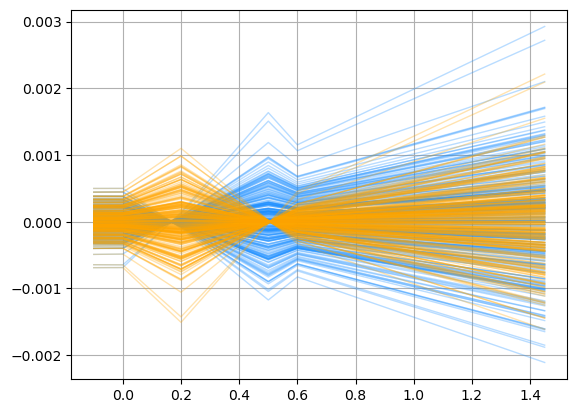

In [94]:

ls = dict(linewidth=1,linestyle='-',marker='o',ms=0, mfc='None', alpha=0.31)
ls['color'] = 'dodgerblue'

xvec = outpos01x
for i in range(invec01.shape[1]):
    yvec = outvec01X[:,0,i]
    
    plt.plot(xvec, yvec,**ls)

ls['color'] = 'orange'
xvec = outpos01y
for i in range(invec01.shape[1]):
    yvec = outvec01Y[:,0,i]
    
    plt.plot(xvec, yvec,**ls)

# plt.axis([outpos01.min(), outpos01.max(), -200e-6, 200e-6])
plt.grid(True)


## test beamlines
---

In [353]:
BL_01 = cl.BeamLine()
for i, ele in enumerate([ele1,ele2]):
    BL_01.add_element(ele)

# BL_01.del_element('lens_03')
mat1 = BL_01.make_mat(-0.00001, 5.0)
print(np.round(mat1,decimals=4))

[0, 4]

In [315]:
rvec1 = np.random.random((2,4))
rvec = np.stack((rvec1,rvec1))

In [316]:
rvec

array([[[0.55129637, 0.97132747, 0.18037606, 0.78324705],
        [0.27332703, 0.05807942, 0.66487332, 0.07525812]],

       [[0.55129637, 0.97132747, 0.18037606, 0.78324705],
        [0.27332703, 0.05807942, 0.66487332, 0.07525812]]])

In [318]:
rvec = np.concatenate((rvec,[rvec1]), axis=0)

In [319]:
rvec

array([[[0.55129637, 0.97132747, 0.18037606, 0.78324705],
        [0.27332703, 0.05807942, 0.66487332, 0.07525812]],

       [[0.55129637, 0.97132747, 0.18037606, 0.78324705],
        [0.27332703, 0.05807942, 0.66487332, 0.07525812]],

       [[0.55129637, 0.97132747, 0.18037606, 0.78324705],
        [0.27332703, 0.05807942, 0.66487332, 0.07525812]]])

In [289]:
np.matmul(mat1,rvec)

array([[[-1.53988226, -0.81105731, -1.06484408, -0.46584901],
        [-2.24576849, -1.59467349, -1.39171721, -0.65388327]],

       [[-1.53988226, -0.81105731, -1.06484408, -0.46584901],
        [-2.24576849, -1.59467349, -1.39171721, -0.65388327]]])

In [290]:
rvec

array([[[0.87810641, 0.07640925, 0.75839686, 0.28956486],
        [0.74979193, 0.78743704, 0.36479316, 0.20251261]],

       [[0.87810641, 0.07640925, 0.75839686, 0.28956486],
        [0.74979193, 0.78743704, 0.36479316, 0.20251261]]])

In [41]:
test = [11,4,51]
sorted(range(len(test)), key=test.__getitem__)

[1, 0, 2]

In [43]:
tt = sorted(range(len(BL_01.element_position)), key=BL_01.element_position.__getitem__)

In [48]:
test = [BL_01.element_position[i] for i in tt]

In [179]:
max(test)

0

In [51]:
bisect.insort(test,-3)

In [54]:
iin = test.index(-3)


In [55]:
alist = ['ele2','ele1']
alist.insert(iin, 'ele3')

In [72]:
ipos = bisect.bisect(test,-4)
test[:ipos]

[-12]

In [73]:
np.matmul(ele1.abcd_mat, ele2.abcd_mat)

array([[1.        , 0.        ],
       [0.18181818, 1.        ]])

In [76]:
cl.ElementABCD('tempdrift', eletype='drift', eleprops={'position':0, 'length':12}).abcd_mat

array([[ 1, 12],
       [ 0,  1]])

array([[ 1. , 29.1],
       [ 0. ,  1. ]])